# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [48]:
from random import random, seed
from itertools import product, accumulate
import numpy as np

from icecream import ic
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [49]:
UNIVERSE_SIZE = 100_000
NUM_SETS = 10_000
DENSITY = 0.3

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [50]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [51]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Have Fun!

In [52]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

(np.True_, np.float64(841060693.7870178))

In [53]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution), cost(solution)

(np.True_, np.float64(423457618.0117961))

### Hill climbing solution

In [54]:
MAX_STEPS = 20_000

# Soluzione con tutti i set inclusi
solution = np.full(NUM_SETS, True)
current_cost = -cost(solution)
history = [current_cost]  # Costi

for n in tqdm(range(MAX_STEPS)):
    # TWEAK! - Modifico in modo randomico la soluzione
    new_solution = solution.copy()
    index = np.random.randint(0, NUM_SETS) 
    new_solution[index] = not new_solution[index] 

    if valid(new_solution):
        new_cost = -cost(new_solution)
        if new_cost > current_cost:
            solution = new_solution
            current_cost = new_cost
        # Aggiorno history con il costo minore finora trovato
        history.append(max(history[-1], new_cost)) #history[-]] è il valore dell'ultimo costo trovato
    else:
        history.append(history[-1])  # Mantengo lo stesso costo se non valido

ic(cost(solution))
ic(history.index(-cost(solution)))

plt.figure(figsize=(14, 8))

# Grafico del costo migliorato nel tempo
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),  # Mostra l'evoluzione del miglior costo
    color="red",
    label='Best cost found so far'
)

# Scatter plot con tutti i costi nel tempo
plt.scatter(range(len(history)), history, marker=".", color="blue", label='Cost at each step')

plt.title("Set Cover Problem")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.legend()
plt.show()


 33%|███▎      | 6552/20000 [51:57<1:46:37,  2.10it/s]


KeyboardInterrupt: 

### Steepest Step and Restart

  7%|▋         | 1316/20000 [00:37<08:56, 34.85it/s] 
ic| cost(best_solution): np.float64(123976.13010810483)
ic| history.index(- cost(best_solution)): 3738


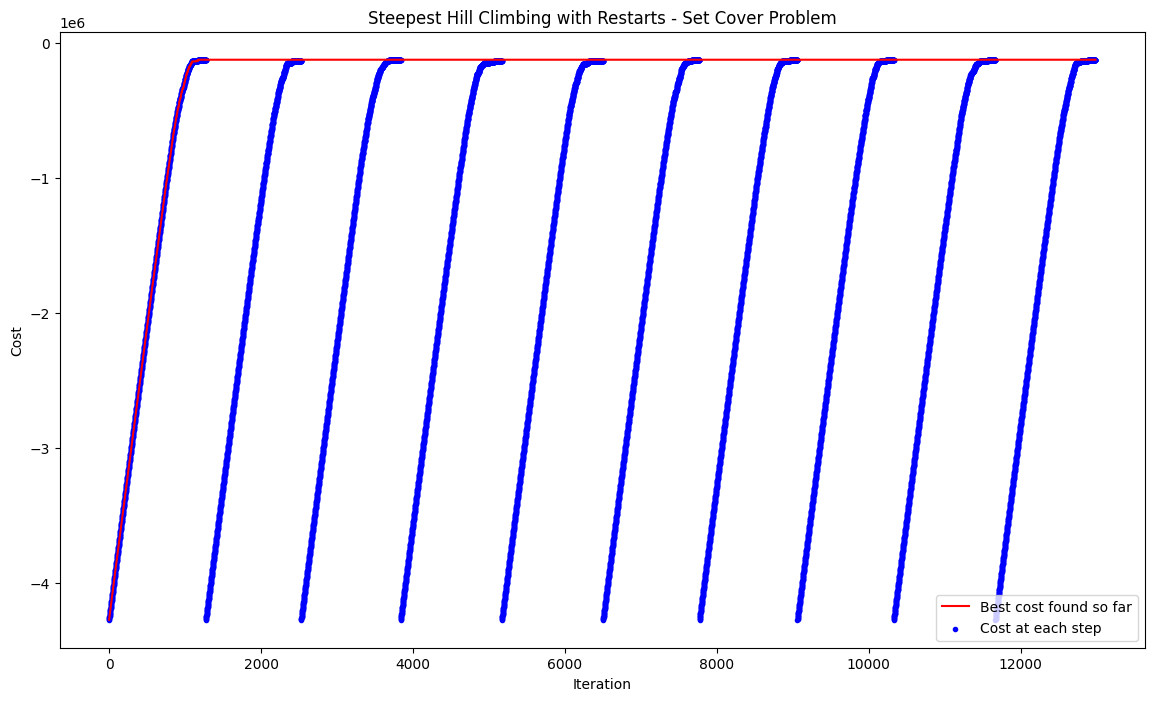

In [40]:
MAX_STEPS = 20_000       # Numero massimo di passi
NEIGHBORHOOD_SIZE = 10  # Numero di vicini esplorati per ogni iterazione
RESTART_THRESHOLD = 100  # Numero massimo di passi senza miglioramento prima di fare un restart
MAX_RESTARTS = 10  # Numero massimo di restart

# Funzione di perturbazione per generare vicini
def tweak_solution(solution):
    new_solution = solution.copy()
    index = np.random.randint(0, NUM_SETS)
    new_solution[index] = not new_solution[index] 
    return new_solution

# Steepest hill climbing with restarts
def steepest_with_restart():
    best_global_solution = None
    best_global_cost = - np.inf
    history = []

    for restart in range(MAX_RESTARTS):
        solution = np.full(NUM_SETS, True)
        current_cost = - cost(solution)
        no_improvement_steps = 0

        for n in tqdm(range(MAX_STEPS)):
            # Miglior vicino tra i Neighbours
            best_neighbor = solution
            best_neighbor_cost = current_cost

            # Esploro vicini
            for _ in range(NEIGHBORHOOD_SIZE):
                new_solution = tweak_solution(solution)

                if valid(new_solution):
                    new_cost = - cost(new_solution)
                    if new_cost > best_neighbor_cost:
                        best_neighbor = new_solution
                        best_neighbor_cost = new_cost

            # Se un vicino è migliore, aggiorno la soluzione corrente
            if best_neighbor_cost > current_cost:
                solution = best_neighbor
                current_cost = best_neighbor_cost
                no_improvement_steps = 0  # Resetto il contatore se c'è stato un miglioramento
            else:
                no_improvement_steps += 1  # Incremento il contatore se non c'è miglioramento

            history.append(current_cost)

            # Controllo la soglia di restart
            if no_improvement_steps >= RESTART_THRESHOLD:
                break

        # Aggiorna il miglior risultato globale
        if current_cost > best_global_cost:
            best_global_solution = solution
            best_global_cost = current_cost

    return best_global_solution, history

# Algoritmo steepest con restart
best_solution, history = steepest_with_restart()

ic(cost(best_solution))
ic(history.index(- cost(best_solution)))


plt.figure(figsize=(14, 8))


# Grafico del costo migliorato nel tempo
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),  # Mostra l'evoluzione del miglior costo
    color="red",
    label='Best cost found so far'
)

plt.scatter(range(len(history)), history, marker=".", color="blue", label='Cost at each step')

plt.title("Steepest Hill Climbing with Restarts - Set Cover Problem")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.legend()

plt.show()
